# Load Data

In [1]:
# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

# misc
import time
from datetime import datetime
# from torchinfo import summary

# preprocessing 
import av
import pandas as pd
import matplotlib.pyplot as plt

# helper classes and functions
from dev_model.model_fns import train
from dev_model.models import CNN_LSTM, VGG_LSTM

# logging
import os
import logging
from torch.utils.tensorboard import SummaryWriter

In [5]:
# create relevant directories

# create dir to save logs if it does not exist
if not os.path.exists("log"):
    os.mkdir("log")

# create dir to save runs if it does not exist
if not os.path.exists("runs"):
    os.mkdir("runs")

# create dir to save models if it does not exist
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")

In [6]:
log_path = "log/cnnlstm_{:%Y-%m-%d_%H-%M-%S}.log".format(datetime.now())
sum_path = "runs/cnnlstm_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now())

# Log to file & tensorboard writer
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logger = logging.getLogger('signo-lingo')
logger.info('Logging to file...')
writer = SummaryWriter(sum_path)

Logging to file...


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
data_dir = "/scratch/rhong5/dataset/signLanguage/AUTSL/"
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

In [9]:
# All labels
filtered_data = "./data"
train_label_df = pd.read_csv(f'{filtered_data}/train.csv', header=None)
test_label_df = pd.read_csv(f'{filtered_data}/test.csv', header=None)
val_label_df = pd.read_csv(f'{filtered_data}/val.csv', header=None)

In [10]:
# Total label + turkish to english translation

total_label = pd.read_csv(f'{filtered_data}/filtered_ClassId.csv')
n_classes = len(total_label['ClassId'].unique())
print("total unique label:", n_classes)


total unique label: 10


# Preprocessing

In [12]:
def extract_frames(vid_path, transforms=None, frames_cap=None): 
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        if frames_cap:
            remainder = n_frames % frames_cap
            interval = n_frames // frames_cap
            take_frame_idx = 0
            if interval < 1:
                raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
        for frame_no, frame in enumerate(container.decode(stream)):
            if frames_cap and frame_no != take_frame_idx:
                continue
            img = frame.to_image()
            if transforms:
                img = transforms(img)
            vid_arr.append(np.array(img))
            if frames_cap:
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    return vid_arr

In [ ]:
import cv2
def extract_frames(vid_path, transforms=None, frames_cap=None):
    """Extract and transform video frames using OpenCV

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr
    """
    vid_arr = []
    cap = cv2.VideoCapture(vid_path)
    if not cap.isOpened():
        raise IOError("Cannot open video file")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frames_cap:
        remainder = total_frames % frames_cap
        interval = total_frames // frames_cap
        take_frame_idx = 0
        if interval < 1:
            raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frames_cap and frame_idx != take_frame_idx:
            frame_idx += 1
            continue

        # Convert BGR to RGB (OpenCV uses BGR by default)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if transforms:
            frame = transforms(frame)

        vid_arr.append(frame)

        if frames_cap:
            if remainder > 0:
                take_frame_idx += 1
                remainder -= 1
            take_frame_idx += interval
        frame_idx += 1

    cap.release()
    return vid_arr


# Custom Dataset

In [13]:
class Turkish_Dataset(Dataset):
    """Custom dataset class for AUTSL Dataset."""
    
    def __init__(self, df, data_dir, n_classes, file_ext=".mp4", transforms=None, frames_cap=None):
        
        self.df = df
        self.frames_cap = frames_cap
        self.transforms = transforms
        self.file_ext = file_ext
        self.data_dir = data_dir
        self.n_classes = n_classes
    
    def __getitem__(self, index):

        vid_name = self.df.iloc[index, 0]
        vid_label = self.df.iloc[index, 1]
        
        vid_color = f"{self.data_dir}/{vid_name}_color{self.file_ext}"

        # get videos
        rgb_arr = extract_frames(vid_color, transforms=self.transforms, frames_cap=self.frames_cap)

        vid_arr = np.array(rgb_arr)

        vid_arr = vid_arr / 255
        
        # create one-hot-encoding for label
        label = np.zeros(self.n_classes)
        label[vid_label] = 1
        
        # convert arr to tensors
        vid_arr = torch.from_numpy(vid_arr).float()
        label = torch.from_numpy(label).long().argmax()
        
        # return masked video array and label
        return vid_arr, label
    
    def __len__(self):
        return len(self.df)

In [15]:
n_frames = 30
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])

shape of first array torch.Size([30, 3, 256, 256])


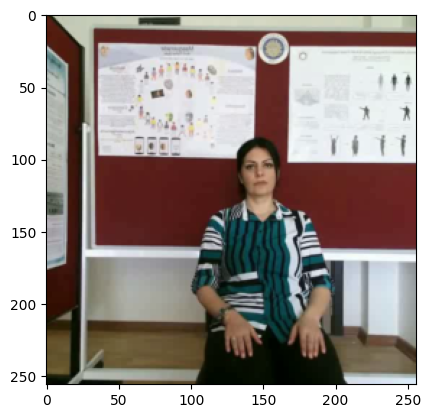

In [16]:
# create train dataset
ld_train = Turkish_Dataset(train_label_df, train_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_train[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_train[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()

plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

In [12]:
# # UNCOMMENT TO SEE SAMPLED FRAMES
# nrows, ncols = 6, 5
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# for i in range(n_frames):
#     row_idx = i // ncols
#     col_idx = i % ncols
#     ax[row_idx][col_idx].imshow(ld_train[0][0][i].numpy().transpose(1, 2, 0))

# # # UNCOMMENT TO SAVE PLOT
# # plt.savefig('train_30_0.png')

# plt.show()

shape of first array torch.Size([30, 3, 256, 256])


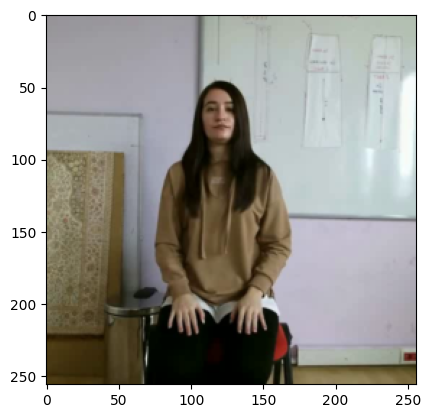

In [17]:
# create test dataset
ld_test = Turkish_Dataset(test_label_df, test_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_test[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_test[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

shape of first array torch.Size([30, 3, 256, 256])


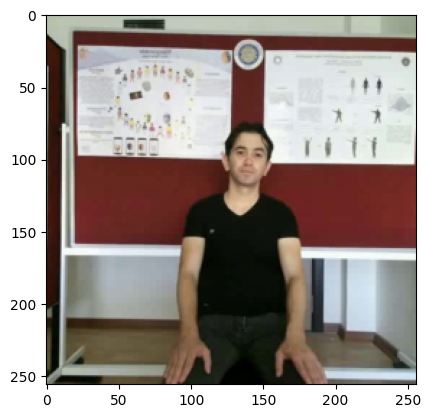

In [18]:
# create val dataset
ld_val = Turkish_Dataset(val_label_df, val_dir, n_classes, transforms=transforms_compose, frames_cap=n_frames)
print("shape of first array", ld_val[0][0].shape)

# show image but clip rbg values
img_np_arr = ld_val[0][0][0].numpy()
img_np_arr -= img_np_arr.min() 
img_np_arr /= img_np_arr.max()
plt.imshow(img_np_arr.transpose(1, 2, 0))
plt.show()

# Custom Dataloader

In [19]:
# create all dataloaders
bs_train = 4
bs_test = 4
bs_val = 4
train_loader = DataLoader(ld_train, batch_size = bs_train, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_test, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

# Train Final Model

In [28]:
from torchsummary import summary

# create model
model = CNN_LSTM(n_classes, 
                 latent_size=512, 
                 n_cnn_layers=6, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True, 
                 bidirectional=True, 
                 dropout_rate=0.8, 
                 attention=True)
summary(model, input_size=(30, 3, 256, 256))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [24]:
# if multiple GPUs are available, wrap model with DataParallel 
if torch.cuda.device_count() > 1:
    logger.info("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [25]:
# hyperparams
no_of_epochs = 1000
optimizer_lr = 1e-5
save_dir = "saved_models/train_final"

In [26]:
# train model
train(model, 
      train_loader, 
      val_loader, 
      no_of_epochs, 
      logger,
      writer,
      save_dir=save_dir, 
      save_checkpoint=True,
      device=device, 
      patience=10, 
      optimizer_lr=optimizer_lr, 
      use_scheduler=True)

/home/rhong5/py39torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
######################Training Started######################
Epoch 1
  0%|          | 0/311 [00:17<?, ?batch/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx